<a href="https://colab.research.google.com/github/MitjaGo/YT/blob/main/ID3TAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📸 Upload a default JPG/PNG thumbnail for all MP3s:


Saving Italiana.jpg to Italiana.jpg


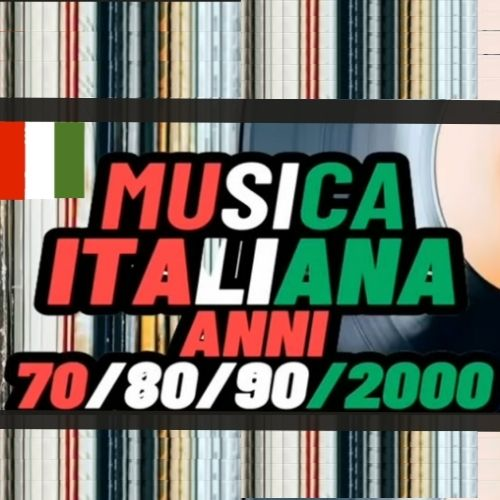


⬆️ Upload up to 50 MP3 files:


Saving 01 - Mina - Oggi Sono Io.mp3 to 01 - Mina - Oggi Sono Io (1).mp3
Saving 02 - Lucio Dalla - Caruso.mp3 to 02 - Lucio Dalla - Caruso (1).mp3
Saving 03 - Marco Ferradini - Teorema.mp3 to 03 - Marco Ferradini - Teorema (1).mp3
Saving 04 - Eros Ramazzotti - Terra Promessa.mp3 to 04 - Eros Ramazzotti - Terra Promessa (1).mp3
Saving 05 - Pooh - Tanta voglia di lei.mp3 to 05 - Pooh - Tanta voglia di lei (1).mp3
✅ Uploaded 5 MP3 files.
🖼️ Default thumbnail embedded into all MP3 files.


Label(value='📝 Edit MP3 Tags and optionally upload new thumbnails:')

Button(button_style='success', description='💾 Save All Tags', style=ButtonStyle())

Button(button_style='info', description='⬇️ Download All MP3s as ZIP', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# ===========================================
# 🧩 INSTALL DEPENDENCIES
# ===========================================
!pip install eyed3 ipywidgets pillow

import eyed3
from google.colab import files
from IPython.display import display, Image
import ipywidgets as widgets
import zipfile
from datetime import datetime
import re
from PIL import Image as PILImage
import io

# ===========================================
# 📸 STEP 1: Upload default thumbnail
# ===========================================
print("📸 Upload a default JPG/PNG thumbnail for all MP3s:")
image_upload = files.upload()
img_name, default_img_data = next(iter(image_upload.items()))
display(Image(data=default_img_data, width=150))

# Resize image for compatibility
def resize_jpeg(img_data, max_size=500):
    img = PILImage.open(io.BytesIO(img_data))
    img.thumbnail((max_size, max_size))
    out = io.BytesIO()
    img.convert("RGB").save(out, format='JPEG', quality=85)
    return out.getvalue()

default_img_data = resize_jpeg(default_img_data)

# ===========================================
# 🎵 STEP 2: Upload MP3 files
# ===========================================
print("\n⬆️ Upload up to 50 MP3 files:")
upload = files.upload()
mp3_files = list(upload.keys())[:50]
print(f"✅ Uploaded {len(mp3_files)} MP3 files.")

# ===========================================
# 🖼️ Helper: Embed thumbnail
# ===========================================
def embed_thumbnail_eyed3(mp3_file, image_data):
    audiofile = eyed3.load(mp3_file)
    if audiofile.tag is None:
        audiofile.initTag()
    audiofile.tag.images.set(3, image_data, "image/jpeg", u"Cover")
    audiofile.tag.save(version=eyed3.id3.ID3_V2_3)

# Embed default thumbnail into all files
for f in mp3_files:
    embed_thumbnail_eyed3(f, default_img_data)
print("🖼️ Default thumbnail embedded into all MP3 files.")

# ===========================================
# 💿 STEP 3: Bulk Album Edit
# ===========================================
bulk_album_widget = widgets.Text(
    value='',
    description='Set Album for All:',
    layout=widgets.Layout(width='300px')
)
bulk_album_btn = widgets.Button(description='Apply to All', button_style='warning')
display(widgets.HBox([bulk_album_widget, bulk_album_btn]))

# ===========================================
# 🧠 STEP 4: Parse filename to extract Artist & Title
# ===========================================
def parse_filename(filename):
    """
    Example: '01 - Mina - Oggi Sono Io.mp3'
    → ('Mina', 'Oggi Sono Io')
    """
    name = re.sub(r'\.\w+$', '', filename)  # remove extension
    parts = re.split(r'\s*-\s*', name)
    parts = [p.strip() for p in parts if p.strip()]

    artist = ""
    title = ""

    if len(parts) >= 3:
        # e.g. ['01', 'Mina', 'Oggi Sono Io']
        artist = parts[1]
        title = " - ".join(parts[2:])
    elif len(parts) == 2:
        # e.g. ['Mina', 'Oggi Sono Io']
        artist, title = parts
    else:
        title = parts[0] if parts else filename

    return artist, title

# ===========================================
# 📝 STEP 5: Create editable widgets per file
# ===========================================
file_widgets = []

for f in mp3_files:
    audiofile = eyed3.load(f)
    if audiofile.tag is None:
        audiofile.initTag()

    # Try to parse filename if tags missing or empty
    parsed_artist, parsed_title = parse_filename(f)

    title = audiofile.tag.title or parsed_title or ""
    artist = audiofile.tag.artist or parsed_artist or ""
    album = audiofile.tag.album or ""

    title_widget = widgets.Text(value=title, description='Title:', layout=widgets.Layout(width='250px'))
    artist_widget = widgets.Text(value=artist, description='Artist:', layout=widgets.Layout(width='250px'))
    album_widget = widgets.Text(value=album, description='Album:', layout=widgets.Layout(width='250px'))
    img_widget = widgets.Image(value=default_img_data, format='jpeg', width=80, height=80)

    new_img_data = {'data': None}

    # Upload per-file thumbnail
    def make_upload_callback(img_w, store):
        def on_upload(change):
            uploaded = files.upload()
            if uploaded:
                _, data = next(iter(uploaded.items()))
                data_resized = resize_jpeg(data)
                img_w.value = data_resized
                store['data'] = data_resized
        return on_upload

    upload_btn = widgets.Button(description="📤 Change Thumbnail", layout=widgets.Layout(width='150px'))
    upload_btn.on_click(make_upload_callback(img_widget, new_img_data))

    hbox = widgets.HBox([
        img_widget,
        widgets.Label(f, layout=widgets.Layout(width='200px')),
        title_widget,
        artist_widget,
        album_widget,
        upload_btn
    ])

    file_widgets.append((f, title_widget, artist_widget, album_widget, img_widget, new_img_data, hbox))

display(widgets.Label("📝 Edit MP3 Tags and optionally upload new thumbnails:"))
for w in file_widgets:
    display(w[-1])

# ===========================================
# 💿 Bulk Album Button Function
# ===========================================
def on_bulk_album_clicked(b):
    album_name = bulk_album_widget.value.strip()
    for _, _, _, album_w, _, _, _ in file_widgets:
        album_w.value = album_name

bulk_album_btn.on_click(on_bulk_album_clicked)

# ===========================================
# 💾 STEP 6: Save & Download
# ===========================================
save_btn = widgets.Button(description="💾 Save All Tags", button_style='success')
zip_btn  = widgets.Button(description="⬇️ Download All MP3s as ZIP", button_style='info')
output   = widgets.Output()
display(save_btn, zip_btn, output)

def clean_filename(filename):
    # remove trailing "(1)" or similar duplicates
    return re.sub(r"\s*\(\d+\)(?=\.\w+$)", "", filename)

# Save all button
def on_save_clicked(b):
    for f, title_w, artist_w, album_w, img_w, new_img, _ in file_widgets:
        audiofile = eyed3.load(f)
        if audiofile.tag is None:
            audiofile.initTag()

        audiofile.tag.title = title_w.value.strip()
        audiofile.tag.artist = artist_w.value.strip()
        audiofile.tag.album = album_w.value.strip()

        image_data = new_img['data'] if new_img['data'] else default_img_data
        audiofile.tag.images.set(3, image_data, "image/jpeg", u"Cover")

        audiofile.tag.save(version=eyed3.id3.ID3_V2_3)

    with output:
        output.clear_output()
        print("✅ All MP3 tags and thumbnails updated successfully!")

# ZIP button
def on_zip_clicked(b):
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    zip_name = f"edited_mp3s_{now}.zip"
    with zipfile.ZipFile(zip_name, "w") as z:
        for f, *_ in file_widgets:
            new_name = clean_filename(f)
            z.write(f, arcname=new_name)
    files.download(zip_name)

save_btn.on_click(on_save_clicked)
zip_btn.on_click(on_zip_clicked)
